## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Мушенко Егор Сергеевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов (1 балл)

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [58]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [59]:
images_train, labels_train = next(iter(train_loader))

In [60]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

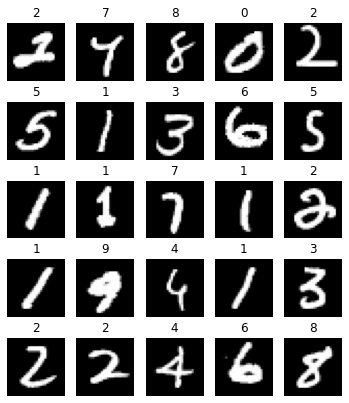

In [61]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [62]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [63]:
network = nn.Sequential(layer)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9881523251533508
backward 0.03018461912870407


D:\Anaconda\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [64]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

def normal(size_input, size_output):
    return 0.1
    #return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

#init_func = normal
init_func = xavier
#init_func = good_grad

for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output))
    
    layers.append(layer)
    #layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())
    layers.append(nn.ReLU())
    
print(len(layers))
del layers[-1]

66


In [65]:
def init_he(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)


init_func = init_he
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9881523251533508
forward 2.8523998260498047
forward 4.295864582061768
forward 5.133740425109863
forward 4.380704402923584
forward 3.095167636871338
forward 3.9245963096618652
forward 3.5195915699005127
forward 2.1165237426757812
forward 1.2567752599716187
forward 1.3328922986984253
forward 1.3744322061538696
forward 1.2520023584365845
forward 1.7088046073913574
forward 1.8586630821228027
forward 1.7968475818634033
forward 1.8718125820159912
forward 1.8507531881332397
forward 1.715314269065857
forward 2.1083366870880127
forward 2.5033161640167236
forward 2.59871506690979
forward 1.919986367225647
forward 1.9215987920761108
forward 2.2032887935638428
forward 0.8891276121139526
forward 0.9162480235099792
forward 0.8565371036529541
forward 0.7499009966850281
forward 0.8529571890830994
forward 0.9331483840942383
forward 0.5242478847503662
forward 0.5494364500045776
backward 0.06045199930667877
backward 0.13530103862285614
backward 0.11858554929494858
backward 0.11147565394639969
b

In [66]:
def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

init_func = xavier
layers = []  
for size_input, size_output in zip(sizes, sizes[1:]):
    
    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(size_input, size_output)) 
    
    layers.append(layer)
    layers.append(nn.ReLU())

network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9881523251533508
forward 0.8111290335655212
forward 0.579407274723053
forward 0.365795373916626
forward 0.2893591821193695
forward 0.1870967149734497
forward 0.0782015472650528
forward 0.05340329930186272
forward 0.038851648569107056
forward 0.026820672675967216
forward 0.022277554497122765
forward 0.010491630993783474
forward 0.006877706851810217
forward 0.003346791723743081
forward 0.0016770283691585064
forward 0.0008538234396837652
forward 0.0006613458972424269
forward 0.0006252704188227654
forward 0.0003422540030442178
forward 0.00024229183327406645
forward 0.00015919921861495823
forward 8.267292287200689e-05
forward 5.1891489420086145e-05
forward 3.474908589851111e-05
forward 2.0669363948400132e-05
forward 1.2868633348261937e-05
forward 5.450041498988867e-06
forward 3.165215275657829e-06
forward 1.6541392824365175e-06
forward 1.842940719143371e-06
forward 1.0899328799496288e-06
forward 8.538224847143283e-07
forward 8.443156502835336e-07
backward 0.04315347224473953
backw

<i> 1.4 Сделайте выводы по первой части </i>

Что Forward, что Backward, и на Xavier, и на he, поначалу, одинаковые, но на Xavier скачки больше.


### Часть 2: Dropout (1 балл)

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [67]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight, requires_grad=False) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [68]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [69]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size_input, size_output))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: ReLU()
2: Dropout(p=0.5, inplace=False)
3: Linear(in_features=128, out_features=128, bias=True)
4: ReLU()
5: Dropout(p=0.5, inplace=False)
6: Linear(in_features=128, out_features=10, bias=True)
7: ReLU()


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.106/0.062	Accuracy: 0.969/0.981


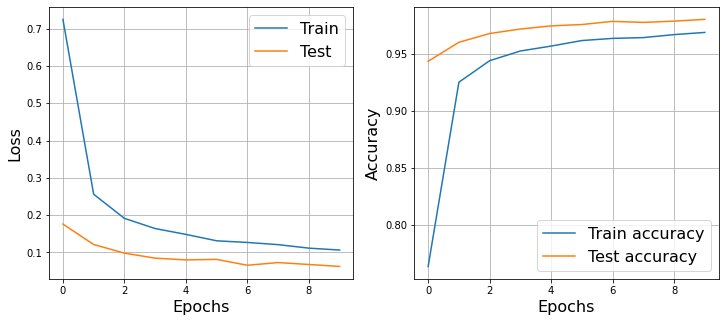

([0.7251730114221573,
  0.2559838202525812,
  0.19123103609407888,
  0.16389770662066525,
  0.14823889010337624,
  0.13104187326231745,
  0.1265993360231426,
  0.12072546076752357,
  0.11132248702731087,
  0.10625123210759686],
 [0.1758901707922356,
  0.12106566418763957,
  0.09796922886154696,
  0.08447211878108969,
  0.0797998979216135,
  0.08114350290049481,
  0.06540983111326452,
  0.07263368776044514,
  0.06749419202509371,
  0.062228977332433946],
 [0.76327074,
  0.92531765,
  0.94425195,
  0.9527807,
  0.9571173,
  0.9619647,
  0.9638748,
  0.96456337,
  0.9672008,
  0.96911645],
 [0.94373024,
  0.960443,
  0.96815664,
  0.97211236,
  0.97488135,
  0.976068,
  0.978837,
  0.977947,
  0.9790348,
  0.9806171])

In [70]:
from google.colab import drive
drive.mount('/dl', force_remount=True)

import sys
sys.path.append('/dl/MyDrive/dl')

import os
os.listdir('/dl/MyDrive/dl')

from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

# Новый раздел

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Точность с Dropout лучше, чем с DropConnect.
Точность на тесте значительно лучше, чем на трейне, так как выходы нейрона зануляются при обучении, как и веса отдельно.

### Часть 3: Batch Normalization (3 балла)

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [71]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, x):
        output = self.alpha * (x - x.mean()) / (x.std() + 1e-8) +  self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [72]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
  layers.append(nn.Linear(size_input, size_output))
  layers.append(nn.BatchNorm1d(size_output))
  layers.append(nn.ReLU())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU()
3: Linear(in_features=128, out_features=128, bias=True)
4: BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5: ReLU()
6: Linear(in_features=128, out_features=10, bias=True)
7: BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.030/0.045	Accuracy: 0.993/0.987


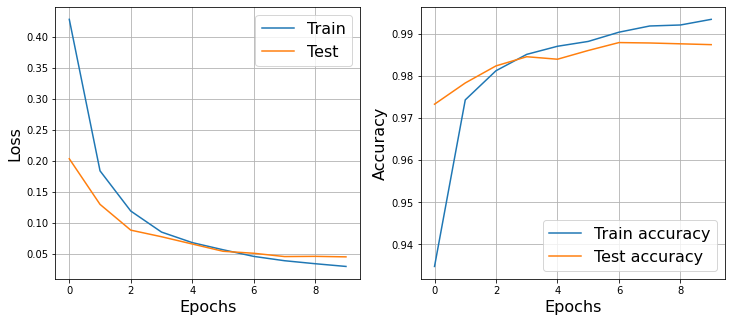

([0.4276841906532804,
  0.18382015644805008,
  0.11910924780120982,
  0.08525782937148232,
  0.0682931071294269,
  0.05680502739065746,
  0.04611754907108446,
  0.03914943231202201,
  0.03431096883899749,
  0.029928257359243406],
 [0.20329262533142597,
  0.129853187293946,
  0.08836491448403913,
  0.07775340300006202,
  0.0660509468775384,
  0.05435437232821803,
  0.0511416798056681,
  0.04584204592989593,
  0.046176238728192036,
  0.04535375442355871],
 [0.93476814,
  0.9743248,
  0.98124886,
  0.98513573,
  0.9870569,
  0.98820627,
  0.9903996,
  0.991871,
  0.9921097,
  0.99344796],
 [0.973299,
  0.9783426,
  0.98239714,
  0.98457277,
  0.9839794,
  0.98605615,
  0.9879351,
  0.98783624,
  0.9876385,
  0.98744065])

In [73]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

In [74]:
sizes = [196, 128, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
  layers.append(nn.Linear(size_input, size_output))
  layers.append(LayerNormalization(size_output))
  layers.append(nn.ReLU())

# исключим активационную на последнем слое
del layers[-1]
[print(f'{i}: {layer}') for i, layer in enumerate(layers)]

0: Linear(in_features=196, out_features=128, bias=True)
1: LayerNormalization()
2: ReLU()
3: Linear(in_features=128, out_features=128, bias=True)
4: LayerNormalization()
5: ReLU()
6: Linear(in_features=128, out_features=10, bias=True)
7: LayerNormalization()


[None, None, None, None, None, None, None, None]

Epoch 9... (Train/Test) NLL: 0.029/0.067	Accuracy: 0.993/0.980


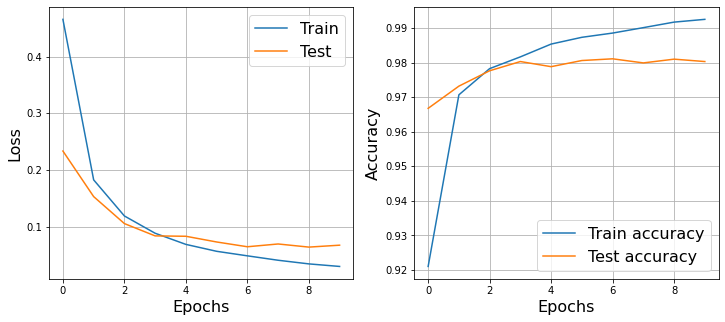

([0.4659181783067138,
  0.18239817450613355,
  0.11862070580471808,
  0.08809731932464185,
  0.06840630644547151,
  0.056204056986835976,
  0.0481940711846452,
  0.040396271049102615,
  0.03396290687244457,
  0.029452486418441795],
 [0.23330906486209435,
  0.15282503241979623,
  0.10516572757800922,
  0.08343003586500505,
  0.08275070350287081,
  0.07267556799269176,
  0.06423264138306244,
  0.0691431765975077,
  0.0636204780680658,
  0.06700581027477791],
 [0.92099214,
  0.9706878,
  0.97827274,
  0.98167646,
  0.98538,
  0.9873401,
  0.98856723,
  0.9901386,
  0.9917377,
  0.9925373],
 [0.96677214,
  0.97320014,
  0.97765034,
  0.9803204,
  0.978837,
  0.9806171,
  0.9811115,
  0.97992486,
  0.98101264,
  0.9803204])

In [75]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Явных отличий между Batch normalization и Layer normalization не выявлено. И там и там на тестовых данных выявлена неустойчивость.



#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: